# Initialize

In [1]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
import mag_initialize as m


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=0

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

# for time series

# total M
def get_total_M(filename,groupname):
    M=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/mass"%groupname)[a:].in_units('Msun')
    return M

def get_total_IE(filename,groupname):
    IE=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/internal_energy"%groupname)[a:].in_units('erg')
    return IE

def get_total_KE(filename,groupname):
    KE=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kinetic_energy"%groupname)[a:].in_units('erg')
    return KE

def get_total_tKE(filename,groupname):
    tKE=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/turbulent_kinetic_energy"%groupname)[a:].in_units('erg')
    return tKE

def get_total_ME(filename,groupname):
    ME=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_energy"%groupname)[a:].in_units('erg')
    return ME

# def IE_M(filename,groupname):
#     return get_total_IE(filename,groupname)/get_total_M(filename,groupname)
# def KE_M(filename,groupname):
#     return get_total_KE(filename,groupname)/get_total_M(filename,groupname)
# def ME_M(filename,groupname):
#     return get_total_ME(filename,groupname)/get_total_M(filename,groupname)

/data/odin/BACKUPS/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/jzuhone/Source/yt/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


# Energy to Mass ratios 3x3 grid 0.15r500

/data/odin/BACKUPS/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1410: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


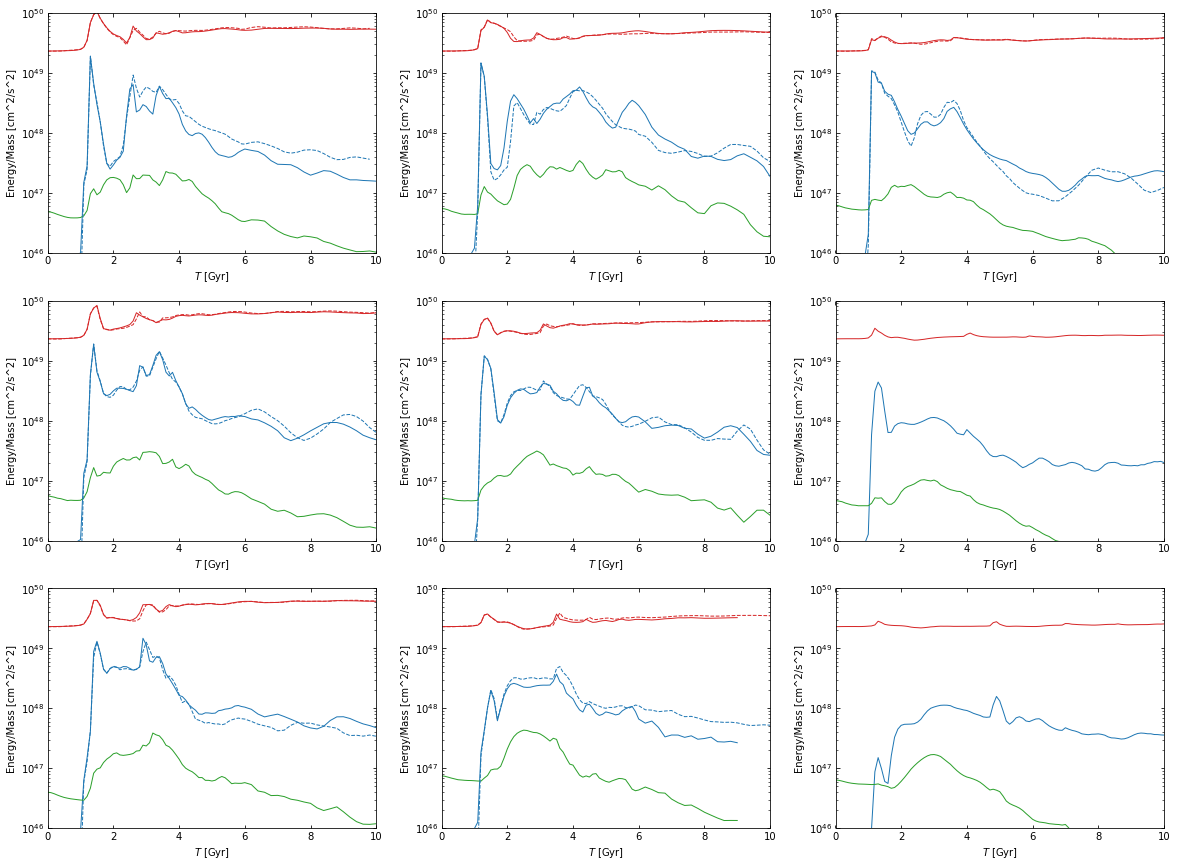

In [5]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=0

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(20, 15))
#plt.subplots_adjust(hspace=0.001)

xlim1=1e-2
xlim2=10
ylim1=1e46
ylim2=1e50
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax11 = m.plt.subplot(331, aspect=num)
ax21 = m.plt.subplot(332, aspect=num)
ax31 = m.plt.subplot(333, aspect=num)
ax12 = m.plt.subplot(334, aspect=num)
ax22 = m.plt.subplot(335, aspect=num)
ax32 = m.plt.subplot(336, aspect=num)
ax13 = m.plt.subplot(337, aspect=num)
ax23 = m.plt.subplot(338, aspect=num)
ax33 = m.plt.subplot(339, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax11, ax21, ax31, ax12, ax22, ax32, ax13, ax23, ax33]

time = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/time"%"time_series_0.15r_500")[a:].in_units('Gyr')
time23 = m.yt.YTArray.from_hdf5(SIM_TYPE23_mag, dataset_name="/%s/time"%"time_series_0.15r_500")[a:].in_units('Gyr')
time31 = m.yt.YTArray.from_hdf5(SIM_TYPE31_mag, dataset_name="/%s/time"%"time_series_0.15r_500")[a:].in_units('Gyr')

time1to1nomag = m.yt.YTArray.from_hdf5(SIM_TYPE11_no_mag, dataset_name="/%s/time"%"time_series_0.15r_500")[a:].in_units('Gyr')
time1to1nomag=list(time1to1nomag)
del time1to1nomag[-1]
time1to1nomag=np.array(time1to1nomag)

mass1to1nomag=list(get_total_M(SIM_TYPE11_no_mag,"time_series_0.15r_500"))
del mass1to1nomag[-1]
mass1to1nomag=np.array(mass1to1nomag)

line_11_IE_M_mag, =ax11.plot(time,get_total_IE(SIM_TYPE11_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE11_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_11_tKE_M_mag, =ax11.plot(time,get_total_tKE(SIM_TYPE11_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE11_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_11_ME_M_mag, =ax11.plot(time,get_total_ME(SIM_TYPE11_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE11_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_11_IE_M_no_mag, =ax11.plot(time1to1nomag,get_total_IE(SIM_TYPE11_no_mag,"time_series_0.15r_500")/mass1to1nomag, 'C3--', lw=1, label="IE/M no mag")
line_11_tKE_M_no_mag, =ax11.plot(time1to1nomag,get_total_tKE(SIM_TYPE11_no_mag,"time_series_0.15r_500")/mass1to1nomag, 'C0--', lw=1, label="tKE/M no mag")

line_12_IE_M_mag, =ax12.plot(time,get_total_IE(SIM_TYPE12_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE12_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_12_tKE_M_mag, =ax12.plot(time,get_total_tKE(SIM_TYPE12_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE12_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_12_ME_M_mag, =ax12.plot(time,get_total_ME(SIM_TYPE12_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE12_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_12_IE_M_no_mag, =ax12.plot(time,get_total_IE(SIM_TYPE12_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE12_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
line_12_tKE_M_no_mag, =ax12.plot(time,get_total_tKE(SIM_TYPE12_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE12_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_13_IE_M_mag, =ax13.plot(time,get_total_IE(SIM_TYPE13_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE13_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_13_tKE_M_mag, =ax13.plot(time,get_total_tKE(SIM_TYPE13_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE13_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_13_ME_M_mag, =ax13.plot(time,get_total_ME(SIM_TYPE13_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE13_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_13_IE_M_no_mag, =ax13.plot(time,get_total_IE(SIM_TYPE13_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE13_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
line_13_tKE_M_no_mag, =ax13.plot(time,get_total_tKE(SIM_TYPE13_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE13_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_21_IE_M_mag, =ax21.plot(time,get_total_IE(SIM_TYPE21_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE21_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_21_tKE_M_mag, =ax21.plot(time,get_total_tKE(SIM_TYPE21_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE21_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_21_ME_M_mag, =ax21.plot(time,get_total_ME(SIM_TYPE21_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE21_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_21_IE_M_no_mag, =ax21.plot(time,get_total_IE(SIM_TYPE21_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE21_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
line_21_tKE_M_no_mag, =ax21.plot(time,get_total_tKE(SIM_TYPE21_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE21_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_22_IE_M_mag, =ax22.plot(time,get_total_IE(SIM_TYPE22_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE22_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_22_tKE_M_mag, =ax22.plot(time,get_total_tKE(SIM_TYPE22_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE22_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_22_ME_M_mag, =ax22.plot(time,get_total_ME(SIM_TYPE22_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE22_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_22_IE_M_no_mag, =ax22.plot(time,get_total_IE(SIM_TYPE22_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE22_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
line_22_tKE_M_no_mag, =ax22.plot(time,get_total_tKE(SIM_TYPE22_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE22_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_23_IE_M_mag, =ax23.plot(time23,get_total_IE(SIM_TYPE23_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE23_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_23_tKE_M_mag, =ax23.plot(time23,get_total_tKE(SIM_TYPE23_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE23_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_23_ME_M_mag, =ax23.plot(time23,get_total_ME(SIM_TYPE23_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE23_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_23_IE_M_no_mag, =ax23.plot(time,get_total_IE(SIM_TYPE23_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE23_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
line_23_tKE_M_no_mag, =ax23.plot(time,get_total_tKE(SIM_TYPE23_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE23_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_31_IE_M_mag, =ax31.plot(time31,get_total_IE(SIM_TYPE31_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE31_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_31_tKE_M_mag, =ax31.plot(time31,get_total_tKE(SIM_TYPE31_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE31_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_31_ME_M_mag, =ax31.plot(time31,get_total_ME(SIM_TYPE31_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE31_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
line_31_IE_M_no_mag, =ax31.plot(time,get_total_IE(SIM_TYPE31_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE31_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
line_31_tKE_M_no_mag, =ax31.plot(time,get_total_tKE(SIM_TYPE31_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE31_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_32_IE_M_mag, =ax32.plot(time31,get_total_IE(SIM_TYPE32_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE32_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_32_tKE_M_mag, =ax32.plot(time31,get_total_tKE(SIM_TYPE32_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE32_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_32_ME_M_mag, =ax32.plot(time31,get_total_ME(SIM_TYPE32_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE32_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
# line_32_IE_M_no_mag, =ax32.plot(time,get_total_IE(SIM_TYPE32_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE32_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
# line_32_tKE_M_no_mag, =ax32.plot(time,get_total_tKE(SIM_TYPE32_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE32_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_33_IE_M_mag, =ax33.plot(time31,get_total_IE(SIM_TYPE33_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE33_mag,"time_series_0.15r_500"), 'C3', lw=1, label="IE/M mag")
line_33_tKE_M_mag, =ax33.plot(time31,get_total_tKE(SIM_TYPE33_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE33_mag,"time_series_0.15r_500"), 'C0', lw=1, label="tKE/M mag")
line_33_ME_M_mag, =ax33.plot(time31,get_total_ME(SIM_TYPE33_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE33_mag,"time_series_0.15r_500"), 'C2', lw=1, label="ME/M mag")
# line_33_IE_M_no_mag, =ax33.plot(time,get_total_IE(SIM_TYPE33_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE33_no_mag,"time_series_0.15r_500"), 'C3--', lw=1, label="IE/M no mag")
# line_33_tKE_M_no_mag, =ax33.plot(time,get_total_tKE(SIM_TYPE33_no_mag,"time_series_0.15r_500")/get_total_M(SIM_TYPE33_no_mag,"time_series_0.15r_500"), 'C0--', lw=1, label="tKE/M no mag")


# add here for 1to10 mass ratio if they are uploaded

# ax11.legend(handles=[line_11_IE_M_mag,line_11_tKE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_tKE_M_no_mag], loc=3)
# ax12.legend(handles=[line_12_IE_M_mag,line_12_tKE_M_mag,line_12_ME_M_mag,line_12_IE_M_no_mag,line_12_tKE_M_no_mag], loc=3)
# ax13.legend(handles=[line_13_IE_M_mag,line_13_tKE_M_mag,line_13_ME_M_mag,line_13_IE_M_no_mag,line_13_tKE_M_no_mag], loc=3)
# ax21.legend(handles=[line_21_IE_M_mag,line_21_tKE_M_mag,line_21_ME_M_mag,line_21_IE_M_no_mag,line_21_tKE_M_no_mag], loc=3)
# ax22.legend(handles=[line_22_IE_M_mag,line_22_tKE_M_mag,line_22_ME_M_mag,line_22_IE_M_no_mag,line_22_tKE_M_no_mag], loc=3)
# ax23.legend(handles=[line_23_IE_M_mag,line_23_tKE_M_mag,line_23_ME_M_mag,line_23_IE_M_no_mag,line_23_tKE_M_no_mag], loc=3)
# ax31.legend(handles=[line_31_IE_M_mag,line_31_tKE_M_mag,line_31_ME_M_mag], loc=3)

# ax32.legend(handles=[line_11_IE_M_mag,line_11_tKE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_tKE_M_no_mag], loc=10)

# ax33.legend(handles=[line_11_IE_M_mag,line_11_tKE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_tKE_M_no_mag], loc=10)



#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("Energy/Mass [cm^2/s^2]") #% get_units(density(SIM_TYPE11_mag,"profiles_0500")))

    #plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$T$ [Gyr]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
#m.plt.tight_layout()
m.plt.show()

# Energy to Mass ratios 3x3 grid 1.0r500

/data/odin/BACKUPS/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1410: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


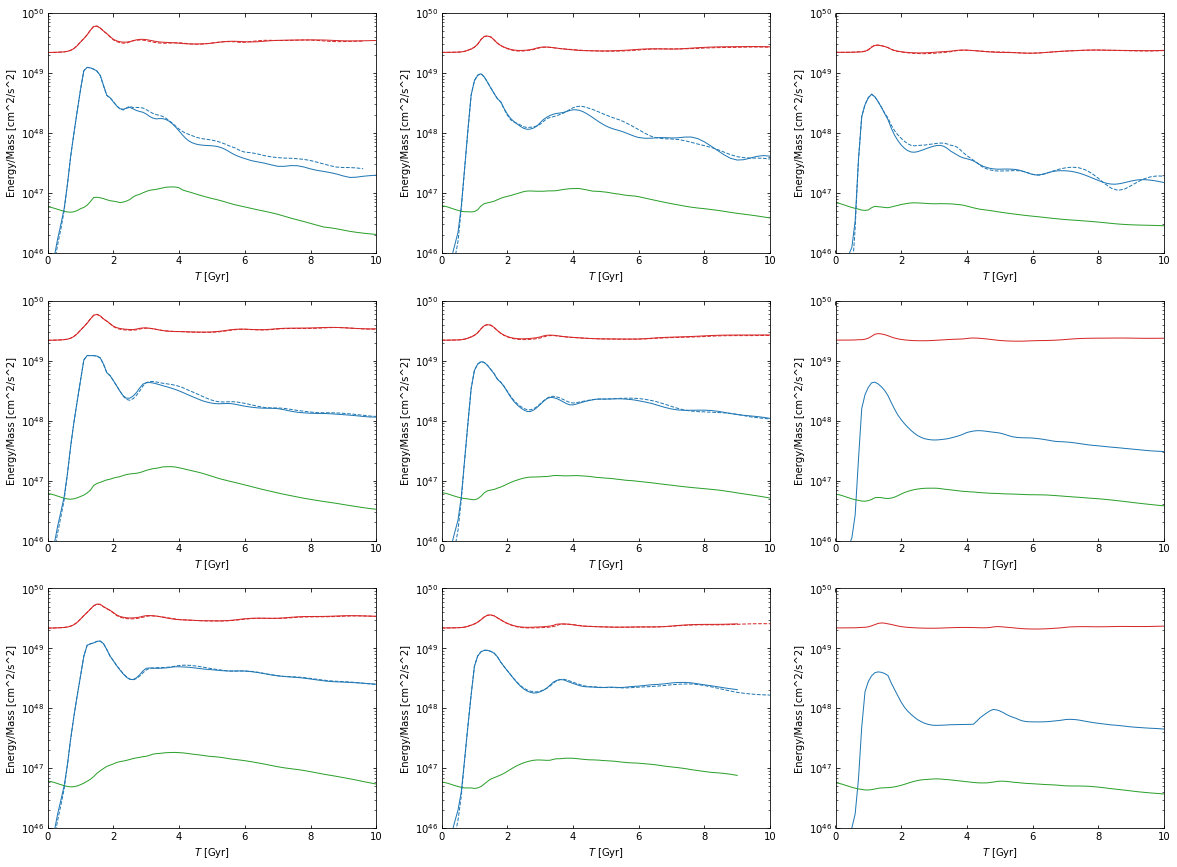

In [7]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=0

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(20, 15))
#plt.subplots_adjust(hspace=0.001)

xlim1=1e-2
xlim2=10
ylim1=1e46
ylim2=1e50
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax11 = m.plt.subplot(331, aspect=num)
ax21 = m.plt.subplot(332, aspect=num)
ax31 = m.plt.subplot(333, aspect=num)
ax12 = m.plt.subplot(334, aspect=num)
ax22 = m.plt.subplot(335, aspect=num)
ax32 = m.plt.subplot(336, aspect=num)
ax13 = m.plt.subplot(337, aspect=num)
ax23 = m.plt.subplot(338, aspect=num)
ax33 = m.plt.subplot(339, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax11, ax21, ax31, ax12, ax22, ax32, ax13, ax23, ax33]

time = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/time"%"time_series_1.0r_500")[a:].in_units('Gyr')
time23 = m.yt.YTArray.from_hdf5(SIM_TYPE23_mag, dataset_name="/%s/time"%"time_series_1.0r_500")[a:].in_units('Gyr')
time31 = m.yt.YTArray.from_hdf5(SIM_TYPE31_mag, dataset_name="/%s/time"%"time_series_1.0r_500")[a:].in_units('Gyr')

time1to1nomag = m.yt.YTArray.from_hdf5(SIM_TYPE12_no_mag, dataset_name="/%s/time"%"time_series_1.0r_500")[a:].in_units('Gyr')
time1to1nomag=list(time1to1nomag)
del time1to1nomag[-1]
del time1to1nomag[-1]
time1to1nomag=np.array(time1to1nomag)

mass1to1nomag=list(get_total_M(SIM_TYPE11_no_mag,"time_series_1.0r_500"))
del mass1to1nomag[-1]
mass1to1nomag=np.array(mass1to1nomag)

line_11_IE_M_mag, =ax11.plot(time,get_total_IE(SIM_TYPE11_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE11_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_11_tKE_M_mag, =ax11.plot(time,get_total_tKE(SIM_TYPE11_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE11_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_11_ME_M_mag, =ax11.plot(time,get_total_ME(SIM_TYPE11_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE11_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_11_IE_M_no_mag, =ax11.plot(time1to1nomag,get_total_IE(SIM_TYPE11_no_mag,"time_series_1.0r_500")/mass1to1nomag, 'C3--', lw=1, label="IE/M no mag")
line_11_tKE_M_no_mag, =ax11.plot(time1to1nomag,get_total_tKE(SIM_TYPE11_no_mag,"time_series_1.0r_500")/mass1to1nomag, 'C0--', lw=1, label="tKE/M no mag")

line_12_IE_M_mag, =ax12.plot(time,get_total_IE(SIM_TYPE12_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE12_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_12_tKE_M_mag, =ax12.plot(time,get_total_tKE(SIM_TYPE12_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE12_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_12_ME_M_mag, =ax12.plot(time,get_total_ME(SIM_TYPE12_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE12_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_12_IE_M_no_mag, =ax12.plot(time,get_total_IE(SIM_TYPE12_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE12_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
line_12_tKE_M_no_mag, =ax12.plot(time,get_total_tKE(SIM_TYPE12_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE12_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_13_IE_M_mag, =ax13.plot(time,get_total_IE(SIM_TYPE13_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE13_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_13_tKE_M_mag, =ax13.plot(time,get_total_tKE(SIM_TYPE13_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE13_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_13_ME_M_mag, =ax13.plot(time,get_total_ME(SIM_TYPE13_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE13_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_13_IE_M_no_mag, =ax13.plot(time,get_total_IE(SIM_TYPE13_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE13_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
line_13_tKE_M_no_mag, =ax13.plot(time,get_total_tKE(SIM_TYPE13_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE13_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_21_IE_M_mag, =ax21.plot(time,get_total_IE(SIM_TYPE21_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE21_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_21_tKE_M_mag, =ax21.plot(time,get_total_tKE(SIM_TYPE21_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE21_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_21_ME_M_mag, =ax21.plot(time,get_total_ME(SIM_TYPE21_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE21_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_21_IE_M_no_mag, =ax21.plot(time,get_total_IE(SIM_TYPE21_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE21_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
line_21_tKE_M_no_mag, =ax21.plot(time,get_total_tKE(SIM_TYPE21_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE21_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_22_IE_M_mag, =ax22.plot(time,get_total_IE(SIM_TYPE22_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE22_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_22_tKE_M_mag, =ax22.plot(time,get_total_tKE(SIM_TYPE22_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE22_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_22_ME_M_mag, =ax22.plot(time,get_total_ME(SIM_TYPE22_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE22_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_22_IE_M_no_mag, =ax22.plot(time,get_total_IE(SIM_TYPE22_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE22_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
line_22_tKE_M_no_mag, =ax22.plot(time,get_total_tKE(SIM_TYPE22_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE22_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_23_IE_M_mag, =ax23.plot(time23,get_total_IE(SIM_TYPE23_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE23_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_23_tKE_M_mag, =ax23.plot(time23,get_total_tKE(SIM_TYPE23_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE23_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_23_ME_M_mag, =ax23.plot(time23,get_total_ME(SIM_TYPE23_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE23_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_23_IE_M_no_mag, =ax23.plot(time,get_total_IE(SIM_TYPE23_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE23_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
line_23_tKE_M_no_mag, =ax23.plot(time,get_total_tKE(SIM_TYPE23_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE23_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_31_IE_M_mag, =ax31.plot(time31,get_total_IE(SIM_TYPE31_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE31_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_31_tKE_M_mag, =ax31.plot(time31,get_total_tKE(SIM_TYPE31_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE31_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_31_ME_M_mag, =ax31.plot(time31,get_total_ME(SIM_TYPE31_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE31_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
line_31_IE_M_no_mag, =ax31.plot(time,get_total_IE(SIM_TYPE31_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE31_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
line_31_tKE_M_no_mag, =ax31.plot(time,get_total_tKE(SIM_TYPE31_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE31_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_32_IE_M_mag, =ax32.plot(time31,get_total_IE(SIM_TYPE32_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE32_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_32_tKE_M_mag, =ax32.plot(time31,get_total_tKE(SIM_TYPE32_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE32_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_32_ME_M_mag, =ax32.plot(time31,get_total_ME(SIM_TYPE32_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE32_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
# line_32_IE_M_no_mag, =ax32.plot(time,get_total_IE(SIM_TYPE32_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE32_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
# line_32_tKE_M_no_mag, =ax32.plot(time,get_total_tKE(SIM_TYPE32_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE32_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

line_33_IE_M_mag, =ax33.plot(time31,get_total_IE(SIM_TYPE33_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE33_mag,"time_series_1.0r_500"), 'C3', lw=1, label="IE/M mag")
line_33_tKE_M_mag, =ax33.plot(time31,get_total_tKE(SIM_TYPE33_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE33_mag,"time_series_1.0r_500"), 'C0', lw=1, label="tKE/M mag")
line_33_ME_M_mag, =ax33.plot(time31,get_total_ME(SIM_TYPE33_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE33_mag,"time_series_1.0r_500"), 'C2', lw=1, label="ME/M mag")
# line_33_IE_M_no_mag, =ax33.plot(time,get_total_IE(SIM_TYPE33_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE33_no_mag,"time_series_1.0r_500"), 'C3--', lw=1, label="IE/M no mag")
# line_33_tKE_M_no_mag, =ax33.plot(time,get_total_tKE(SIM_TYPE33_no_mag,"time_series_1.0r_500")/get_total_M(SIM_TYPE33_no_mag,"time_series_1.0r_500"), 'C0--', lw=1, label="tKE/M no mag")

# add here for 1to10 mass ratio if they are uploaded

# ax11.legend(handles=[line_11_IE_M_mag,line_11_tKE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_tKE_M_no_mag], loc=3)
# ax12.legend(handles=[line_12_IE_M_mag,line_12_tKE_M_mag,line_12_ME_M_mag,line_12_IE_M_no_mag,line_12_tKE_M_no_mag], loc=3)
# ax13.legend(handles=[line_13_IE_M_mag,line_13_tKE_M_mag,line_13_ME_M_mag,line_13_IE_M_no_mag,line_13_tKE_M_no_mag], loc=3)
# ax21.legend(handles=[line_21_IE_M_mag,line_21_tKE_M_mag,line_21_ME_M_mag,line_21_IE_M_no_mag,line_21_tKE_M_no_mag], loc=3)
# ax22.legend(handles=[line_22_IE_M_mag,line_22_tKE_M_mag,line_22_ME_M_mag,line_22_IE_M_no_mag,line_22_tKE_M_no_mag], loc=3)
# ax23.legend(handles=[line_23_IE_M_mag,line_23_tKE_M_mag,line_23_ME_M_mag,line_23_IE_M_no_mag,line_23_tKE_M_no_mag], loc=3)
# ax31.legend(handles=[line_31_IE_M_mag,line_31_tKE_M_mag,line_31_ME_M_mag], loc=3)

# ax32.legend(handles=[line_11_IE_M_mag,line_11_tKE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_tKE_M_no_mag], loc=10)

# ax33.legend(handles=[line_11_IE_M_mag,line_11_tKE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_tKE_M_no_mag], loc=10)



#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("Energy/Mass [cm^2/s^2]") #% get_units(density(SIM_TYPE11_mag,"profiles_0500")))

    #plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$T$ [Gyr]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
#m.plt.tight_layout()
m.plt.show()

# Energy to Mass ratios 3x3 grid entire box 
# >>Unfinished<< total mass/energies aren't stored yet

In [ ]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=0

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(20, 15))
#plt.subplots_adjust(hspace=0.001)

xlim1=1e-2
xlim2=10
ylim1=1e46
ylim2=1e50
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax11 = m.plt.subplot(331, aspect=num)
ax21 = m.plt.subplot(332, aspect=num)
ax31 = m.plt.subplot(333, aspect=num)
ax12 = m.plt.subplot(334, aspect=num)
ax22 = m.plt.subplot(335, aspect=num)
ax32 = m.plt.subplot(336, aspect=num)
ax13 = m.plt.subplot(337, aspect=num)
ax23 = m.plt.subplot(338, aspect=num)
ax33 = m.plt.subplot(339, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax11, ax21, ax31, ax12, ax22, ax32, ax13, ax23, ax33]

time = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/time"%"time_series_1.0r_500_gpm1")[a:].in_units('Gyr')
time23 = m.yt.YTArray.from_hdf5(SIM_TYPE23_mag, dataset_name="/%s/time"%"time_series_1.0r_500_gpm1")[a:].in_units('Gyr')
time31 = m.yt.YTArray.from_hdf5(SIM_TYPE31_mag, dataset_name="/%s/time"%"time_series_1.0r_500_gpm1")[a:].in_units('Gyr')

time1to1nomag = m.yt.YTArray.from_hdf5(SIM_TYPE12_no_mag, dataset_name="/%s/time"%"time_series_1.0r_500_gpm1")[a:].in_units('Gyr')
time1to1nomag=list(time1to1nomag)
del time1to1nomag[-1]
del time1to1nomag[-1]
time1to1nomag=np.array(time1to1nomag)

mass1to1nomag=list(get_total_M(SIM_TYPE11_no_mag,"time_series_1.0r_500_gpm1"))
del mass1to1nomag[-1]
mass1to1nomag=np.array(mass1to1nomag)

line_11_IE_M_mag, =ax11.plot(time,get_total_IE(SIM_TYPE11_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE11_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_11_KE_M_mag, =ax11.plot(time,get_total_KE(SIM_TYPE11_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE11_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_11_ME_M_mag, =ax11.plot(time,get_total_ME(SIM_TYPE11_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE11_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")
line_11_IE_M_no_mag, =ax11.plot(time1to1nomag,get_total_IE(SIM_TYPE11_no_mag,"time_series_1.0r_500_gpm1")/mass1to1nomag, 'C3--', lw=1, label="IE/M no mag")
line_11_KE_M_no_mag, =ax11.plot(time1to1nomag,get_total_KE(SIM_TYPE11_no_mag,"time_series_1.0r_500_gpm1")/mass1to1nomag, 'C0--', lw=1, label="KE/M no mag")

line_12_IE_M_mag, =ax12.plot(time,get_total_IE(SIM_TYPE12_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE12_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_12_KE_M_mag, =ax12.plot(time,get_total_KE(SIM_TYPE12_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE12_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_12_ME_M_mag, =ax12.plot(time,get_total_ME(SIM_TYPE12_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE12_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")
line_12_IE_M_no_mag, =ax12.plot(time,get_total_IE(SIM_TYPE12_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE12_no_mag,"time_series_1.0r_500_gpm1"), 'C3--', lw=1, label="IE/M no mag")
line_12_KE_M_no_mag, =ax12.plot(time,get_total_KE(SIM_TYPE12_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE12_no_mag,"time_series_1.0r_500_gpm1"), 'C0--', lw=1, label="KE/M no mag")

line_13_IE_M_mag, =ax13.plot(time,get_total_IE(SIM_TYPE13_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE13_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_13_KE_M_mag, =ax13.plot(time,get_total_KE(SIM_TYPE13_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE13_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_13_ME_M_mag, =ax13.plot(time,get_total_ME(SIM_TYPE13_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE13_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")
line_13_IE_M_no_mag, =ax13.plot(time,get_total_IE(SIM_TYPE13_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE13_no_mag,"time_series_1.0r_500_gpm1"), 'C3--', lw=1, label="IE/M no mag")
line_13_KE_M_no_mag, =ax13.plot(time,get_total_KE(SIM_TYPE13_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE13_no_mag,"time_series_1.0r_500_gpm1"), 'C0--', lw=1, label="KE/M no mag")

line_21_IE_M_mag, =ax21.plot(time,get_total_IE(SIM_TYPE21_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE21_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_21_KE_M_mag, =ax21.plot(time,get_total_KE(SIM_TYPE21_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE21_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_21_ME_M_mag, =ax21.plot(time,get_total_ME(SIM_TYPE21_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE21_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")
line_21_IE_M_no_mag, =ax21.plot(time,get_total_IE(SIM_TYPE21_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE21_no_mag,"time_series_1.0r_500_gpm1"), 'C3--', lw=1, label="IE/M no mag")
line_21_KE_M_no_mag, =ax21.plot(time,get_total_KE(SIM_TYPE21_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE21_no_mag,"time_series_1.0r_500_gpm1"), 'C0--', lw=1, label="KE/M no mag")

line_22_IE_M_mag, =ax22.plot(time,get_total_IE(SIM_TYPE22_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE22_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_22_KE_M_mag, =ax22.plot(time,get_total_KE(SIM_TYPE22_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE22_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_22_ME_M_mag, =ax22.plot(time,get_total_ME(SIM_TYPE22_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE22_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")
line_22_IE_M_no_mag, =ax22.plot(time,get_total_IE(SIM_TYPE22_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE22_no_mag,"time_series_1.0r_500_gpm1"), 'C3--', lw=1, label="IE/M no mag")
line_22_KE_M_no_mag, =ax22.plot(time,get_total_KE(SIM_TYPE22_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE22_no_mag,"time_series_1.0r_500_gpm1"), 'C0--', lw=1, label="KE/M no mag")

line_23_IE_M_mag, =ax23.plot(time23,get_total_IE(SIM_TYPE23_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE23_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_23_KE_M_mag, =ax23.plot(time23,get_total_KE(SIM_TYPE23_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE23_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_23_ME_M_mag, =ax23.plot(time23,get_total_ME(SIM_TYPE23_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE23_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")
line_23_IE_M_no_mag, =ax23.plot(time,get_total_IE(SIM_TYPE23_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE23_no_mag,"time_series_1.0r_500_gpm1"), 'C3--', lw=1, label="IE/M no mag")
line_23_KE_M_no_mag, =ax23.plot(time,get_total_KE(SIM_TYPE23_no_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE23_no_mag,"time_series_1.0r_500_gpm1"), 'C0--', lw=1, label="KE/M no mag")

line_31_IE_M_mag, =ax31.plot(time31,get_total_IE(SIM_TYPE31_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE31_mag,"time_series_1.0r_500_gpm1"), 'C3', lw=1, label="IE/M mag")
line_31_KE_M_mag, =ax31.plot(time31,get_total_KE(SIM_TYPE31_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE31_mag,"time_series_1.0r_500_gpm1"), 'C0', lw=1, label="KE/M mag")
line_31_ME_M_mag, =ax31.plot(time31,get_total_ME(SIM_TYPE31_mag,"time_series_1.0r_500_gpm1")/get_total_M(SIM_TYPE31_mag,"time_series_1.0r_500_gpm1"), 'C2', lw=1, label="ME/M mag")

# add here for 1to10 mass ratio if they are uploaded

# ax11.legend(handles=[line_11_IE_M_mag,line_11_KE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_KE_M_no_mag], loc=3)
# ax12.legend(handles=[line_12_IE_M_mag,line_12_KE_M_mag,line_12_ME_M_mag,line_12_IE_M_no_mag,line_12_KE_M_no_mag], loc=3)
# ax13.legend(handles=[line_13_IE_M_mag,line_13_KE_M_mag,line_13_ME_M_mag,line_13_IE_M_no_mag,line_13_KE_M_no_mag], loc=3)
# ax21.legend(handles=[line_21_IE_M_mag,line_21_KE_M_mag,line_21_ME_M_mag,line_21_IE_M_no_mag,line_21_KE_M_no_mag], loc=3)
# ax22.legend(handles=[line_22_IE_M_mag,line_22_KE_M_mag,line_22_ME_M_mag,line_22_IE_M_no_mag,line_22_KE_M_no_mag], loc=3)
# ax23.legend(handles=[line_23_IE_M_mag,line_23_KE_M_mag,line_23_ME_M_mag,line_23_IE_M_no_mag,line_23_KE_M_no_mag], loc=3)
# ax31.legend(handles=[line_31_IE_M_mag,line_31_KE_M_mag,line_31_ME_M_mag], loc=3)

ax32.legend(handles=[line_11_IE_M_mag,line_11_KE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_KE_M_no_mag], loc=10)

ax33.legend(handles=[line_11_IE_M_mag,line_11_KE_M_mag,line_11_ME_M_mag,line_11_IE_M_no_mag,line_11_KE_M_no_mag], loc=10)



#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("Energy/Mass [cm^2/s^2]") #% get_units(density(SIM_TYPE11_mag,"profiles_0500")))

    #plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$T$ [Gyr]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
#m.plt.tight_layout()
m.plt.show()

In [3]:
len(time1to1nomag)

59

In [4]:
len(time)

61

In [5]:
len(get_total_KE(SIM_TYPE11_no_mag,"time_series_0.15r_500_gpm1"))

59

In [6]:
len(mass1to1nomag)

59

In [10]:
len(m.yt.YTArray.from_hdf5(SIM_TYPE23_mag, dataset_name="/%s/time"%"time_series_0.15r_500_gpm1").in_units('Gyr'))

76

In [22]:
len(get_total_KE(SIM_TYPE12_mag,"time_series_0.15r_500_gpm1"))
len(get_total_M(SIM_TYPE12_mag,"time_series_0.15r_500_gpm1"))

81

In [12]:
get_total_tKE(SIM_TYPE11_mag,"time_series_0.15r_500")

YTArray([  1.25065862e+54,   2.69281421e+57,   6.65717613e+57,
         9.57269698e+57,   1.21899552e+58,   1.55461770e+58,
         1.81196095e+58,   2.08878260e+58,   2.44827820e+58,
         2.78179784e+58,   3.11140097e+58,   4.96047728e+59,
         1.12832036e+60,   1.31971588e+62,   3.37685412e+61,
         7.34646955e+60,   2.32543012e+60,   7.55157500e+59,
         3.06140887e+59,   2.26814787e+59,   2.64795305e+59,
         3.38884816e+59,   4.30318390e+59,   7.23125251e+59,
         4.15571346e+60,   1.54491535e+61,   2.49201775e+61,
         7.11174350e+60,   7.70984269e+60,   8.88654484e+60,
         7.10828076e+60,   5.47018712e+60,   4.61230426e+60,
         1.00221961e+61,   1.70863069e+61,   1.31696923e+61,
         1.03621628e+61,   1.07714428e+61,   8.72145261e+60,
         6.66669017e+60,   5.23885222e+60,   3.41168884e+60,
         2.59696908e+60,   2.29979005e+60,   2.25168384e+60,
         2.47895625e+60,   2.53638425e+60,   2.39586148e+60,
         2.11361491e+6

In [13]:
get_total_KE(SIM_TYPE11_mag,"time_series_0.15r_500")

YTArray([  1.34049680e+61,   1.47656557e+61,   1.65576397e+61,
         1.86909552e+61,   2.13264385e+61,   2.44923146e+61,
         2.83628627e+61,   3.32112703e+61,   3.94262155e+61,
         4.77422352e+61,   5.94332567e+61,   7.41868748e+61,
         9.33643370e+61,   1.49015326e+62,   3.87413852e+61,
         1.38980396e+61,   1.16891741e+61,   7.98681104e+60,
         5.27779887e+60,   3.79285644e+60,   3.12460578e+60,
         3.09186946e+60,   3.62241183e+60,   6.22758287e+60,
         1.45270509e+61,   2.07312688e+61,   2.50646329e+61,
         1.64765261e+61,   9.38742835e+60,   9.17282482e+60,
         9.77620209e+60,   9.58544178e+60,   1.07556911e+61,
         1.40601608e+61,   1.72638884e+61,   1.32935052e+61,
         1.04372950e+61,   1.10998851e+61,   9.70541766e+60,
         6.98167668e+60,   5.35188467e+60,   4.32961241e+60,
         3.57208408e+60,   3.11567208e+60,   2.94670571e+60,
         2.91724534e+60,   2.78128952e+60,   2.47775680e+60,
         2.13238044e+6

In [11]:
get_total_tKE(SIM_TYPE13_mag,"time_series_0.15r_500")==get_total_KE(SIM_TYPE13_mag,"time_series_0.15r_500")

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)